In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.impute import KNNImputer
import datetime as dt
import sqlite3
import sys

import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from patsy import dmatrices

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz
from sklearn.datasets import make_classification
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
import pickle
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
import missingpy
from missingpy import MissForest

import requests
import traceback
from sqlalchemy import create_engine, MetaData, Table, Column, Integer, Float, String, DateTime

# import graphviz
# from graphviz import Source

# hide ipykernel warnings 
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

<p>Read cleaned trips data into dataframe.</p>

In [2]:
df = pd.read_csv("initial_trips_cleaning.csv")

In [3]:
df.shape

(2124294, 9)

In [4]:
df.head()

,TRIPID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,dt
0,6253783,68,68_80,1,87245,84600,87524.0,84600.0,2018-02-07 23:00:00
1,6262138,25B,25B_271,2,30517,26460,32752.0,NaN,2018-02-07 07:00:00
2,6254942,45A,45A_70,2,35512,32100,36329.0,32082.0,2018-02-07 08:00:00
3,6259460,25A,25A_273,1,57261,54420,58463.0,54443.0,2018-02-07 15:00:00
4,6253175,14,14_15,1,85383,81600,84682.0,81608.0,2018-02-07 22:00:00


In [5]:
df.dtypes

TRIPID               int64
LINEID              object
ROUTEID             object
DIRECTION            int64
PLANNEDTIME_ARR      int64
PLANNEDTIME_DEP      int64
ACTUALTIME_ARR     float64
ACTUALTIME_DEP     float64
dt                  object
dtype: object

In [6]:
# Cast types - LINEID to ensure all entries are of type string
df["LINEID"] = df["LINEID"].astype(str)
df["dt"] = df["dt"].astype("datetime64")

In [7]:
df.dtypes

TRIPID                      int64
LINEID                     object
ROUTEID                    object
DIRECTION                   int64
PLANNEDTIME_ARR             int64
PLANNEDTIME_DEP             int64
ACTUALTIME_ARR            float64
ACTUALTIME_DEP            float64
dt                 datetime64[ns]
dtype: object

In [8]:
df.LINEID.unique()

array(['68', '25B', '45A', '25A', '14', '77A', '39', '16', '40D', '27B',
       '142', '83', '130', '15', '46A', '33', '7', '39A', '49', '1',
       '123', '41', '67X', '59', '9', '40', '239', '76', '84', '53',
       '185', '151', '13', '15B', '65B', '29A', '61', '140', '79A', '38A',
       '31', '33B', '69', '44', '42', '67', '184', '238', '145', '17A',
       '32', '27A', '17', '27X', '122', '54A', '66', '150', '56A', '37',
       '27', '15A', '65', '11', '47', '79', '83A', '63', '4', '120',
       '41C', '70', '84A', '220', '32X', '68A', '84X', '38', '102', '270',
       '51X', '33X', '75', '26', '66A', '31A', '111', '18', '14C', '114',
       '76A', '44B', '7A', '43', '25', '104', '33A', '16C', '42D', '31B',
       '66X', '31D', '33D', '39X', '41B', '40B', '7D', '46E', '118',
       '51D', '15D', '41A', '25D', '38D', '66B', '38B', '236', '7B',
       '41X', '40E', '161', '70D', '69X', '116', '77X', '25X', '68X',
       '16D', '33E', '41D'], dtype=object)

<p>Read cleaned weather data into dataframe.</p>

In [9]:
weather_df = pd.read_csv("weather_cleaned_all_features.csv")

In [10]:
weather_df.head()

,dt,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_main
0,2018-01-01 00:00:00,4.15,-6.49,3.84,5.79,990,87,12.86,240,40,Rain
1,2018-01-01 01:00:00,4.14,-5.79,3.65,5.86,991,87,11.83,240,75,Rain
2,2018-01-01 02:00:00,4.61,-5.77,3.85,5.99,990,81,12.35,240,40,Clouds
3,2018-01-01 03:00:00,4.64,-5.73,4.00,6.14,990,81,12.35,240,40,Clouds
4,2018-01-01 04:00:00,5.04,-4.91,4.11,6.22,990,81,11.83,240,40,Clouds


In [11]:
weather_df.shape

(8760, 11)

In [12]:
weather_df.dtypes

dt               object
temp            float64
feels_like      float64
temp_min        float64
temp_max        float64
pressure          int64
humidity          int64
wind_speed      float64
wind_deg          int64
clouds_all        int64
weather_main     object
dtype: object

In [13]:
weather_df["dt"] = weather_df["dt"].astype("datetime64")
weather_df["weather_main"] = weather_df["weather_main"].astype("category")

<p>Merge the dataframes.</p>

In [14]:
merged = df.merge(weather_df, on="dt", how="left")

In [15]:
merged.head()

,TRIPID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,dt,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_main
0,6253783,68,68_80,1,87245,84600,87524.0,84600.0,2018-02-07 23:00:00,5.44,-1.02,4.06,6.00,1015,87,7.20,220,75,Clouds
1,6262138,25B,25B_271,2,30517,26460,32752.0,NaN,2018-02-07 07:00:00,-1.60,-7.53,-2.00,1.75,1023,93,5.14,270,20,Clouds
2,6254942,45A,45A_70,2,35512,32100,36329.0,32082.0,2018-02-07 08:00:00,-1.22,-6.26,-2.00,1.77,1023,100,4.12,250,40,Clouds
3,6259460,25A,25A_273,1,57261,54420,58463.0,54443.0,2018-02-07 15:00:00,3.55,-1.79,2.93,4.21,1021,87,5.14,230,90,Drizzle
4,6253175,14,14_15,1,85383,81600,84682.0,81608.0,2018-02-07 22:00:00,5.02,-2.60,4.46,5.61,1016,87,8.75,230,75,Clouds


In [16]:
merged.columns

Index(['TRIPID', 'LINEID', 'ROUTEID', 'DIRECTION', 'PLANNEDTIME_ARR',
       'PLANNEDTIME_DEP', 'ACTUALTIME_ARR', 'ACTUALTIME_DEP', 'dt', 'temp',
       'feels_like', 'temp_min', 'temp_max', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'clouds_all', 'weather_main'],
      dtype='object')

In [17]:
merged.shape

(2124294, 19)

In [18]:
merged.isna().sum()

TRIPID                  0
LINEID                  0
ROUTEID                 0
DIRECTION               0
PLANNEDTIME_ARR         0
PLANNEDTIME_DEP         0
ACTUALTIME_ARR     115904
ACTUALTIME_DEP     124009
dt                      0
temp                    0
feels_like              0
temp_min                0
temp_max                0
pressure                0
humidity                0
wind_speed              0
wind_deg                0
clouds_all              0
weather_main            0
dtype: int64

<p>Missing values for ACTUALTIME_ARR and ACTUALTIME_DEP will later be imputed. Now we will look for correlation between features. Feature JOURNEYTIME will be created temporarily in order to evaluate correlation between each of the input features and JOURNEYTIME, which will ultimately be our target feature, but which will be removed during imputation.</p>

In [19]:
merged["JOURNEYTIME"] = merged["ACTUALTIME_ARR"] - merged["ACTUALTIME_DEP"]

In [20]:
merged.head()

,TRIPID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,dt,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_main,JOURNEYTIME
0,6253783,68,68_80,1,87245,84600,87524.0,84600.0,2018-02-07 23:00:00,5.44,-1.02,4.06,6.00,1015,87,7.20,220,75,Clouds,2924.0
1,6262138,25B,25B_271,2,30517,26460,32752.0,NaN,2018-02-07 07:00:00,-1.60,-7.53,-2.00,1.75,1023,93,5.14,270,20,Clouds,NaN
2,6254942,45A,45A_70,2,35512,32100,36329.0,32082.0,2018-02-07 08:00:00,-1.22,-6.26,-2.00,1.77,1023,100,4.12,250,40,Clouds,4247.0
3,6259460,25A,25A_273,1,57261,54420,58463.0,54443.0,2018-02-07 15:00:00,3.55,-1.79,2.93,4.21,1021,87,5.14,230,90,Drizzle,4020.0
4,6253175,14,14_15,1,85383,81600,84682.0,81608.0,2018-02-07 22:00:00,5.02,-2.60,4.46,5.61,1016,87,8.75,230,75,Clouds,3074.0


In [21]:
merged.dtypes

TRIPID                      int64
LINEID                     object
ROUTEID                    object
DIRECTION                   int64
PLANNEDTIME_ARR             int64
PLANNEDTIME_DEP             int64
ACTUALTIME_ARR            float64
ACTUALTIME_DEP            float64
dt                 datetime64[ns]
temp                      float64
feels_like                float64
temp_min                  float64
temp_max                  float64
pressure                    int64
humidity                    int64
wind_speed                float64
wind_deg                    int64
clouds_all                  int64
weather_main             category
JOURNEYTIME               float64
dtype: object

<p>Plot a correlation matrix to explore correlation between target feature JOURNEYTIME and numeric features.</p>

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5]),
 [Text(0.5, 0, 'TRIPID'),
  Text(1.5, 0, 'DIRECTION'),
  Text(2.5, 0, 'PLANNEDTIME_ARR'),
  Text(3.5, 0, 'PLANNEDTIME_DEP'),
  Text(4.5, 0, 'ACTUALTIME_ARR'),
  Text(5.5, 0, 'ACTUALTIME_DEP'),
  Text(6.5, 0, 'temp'),
  Text(7.5, 0, 'feels_like'),
  Text(8.5, 0, 'temp_min'),
  Text(9.5, 0, 'temp_max'),
  Text(10.5, 0, 'pressure'),
  Text(11.5, 0, 'humidity'),
  Text(12.5, 0, 'wind_speed'),
  Text(13.5, 0, 'wind_deg'),
  Text(14.5, 0, 'clouds_all'),
  Text(15.5, 0, 'JOURNEYTIME')])

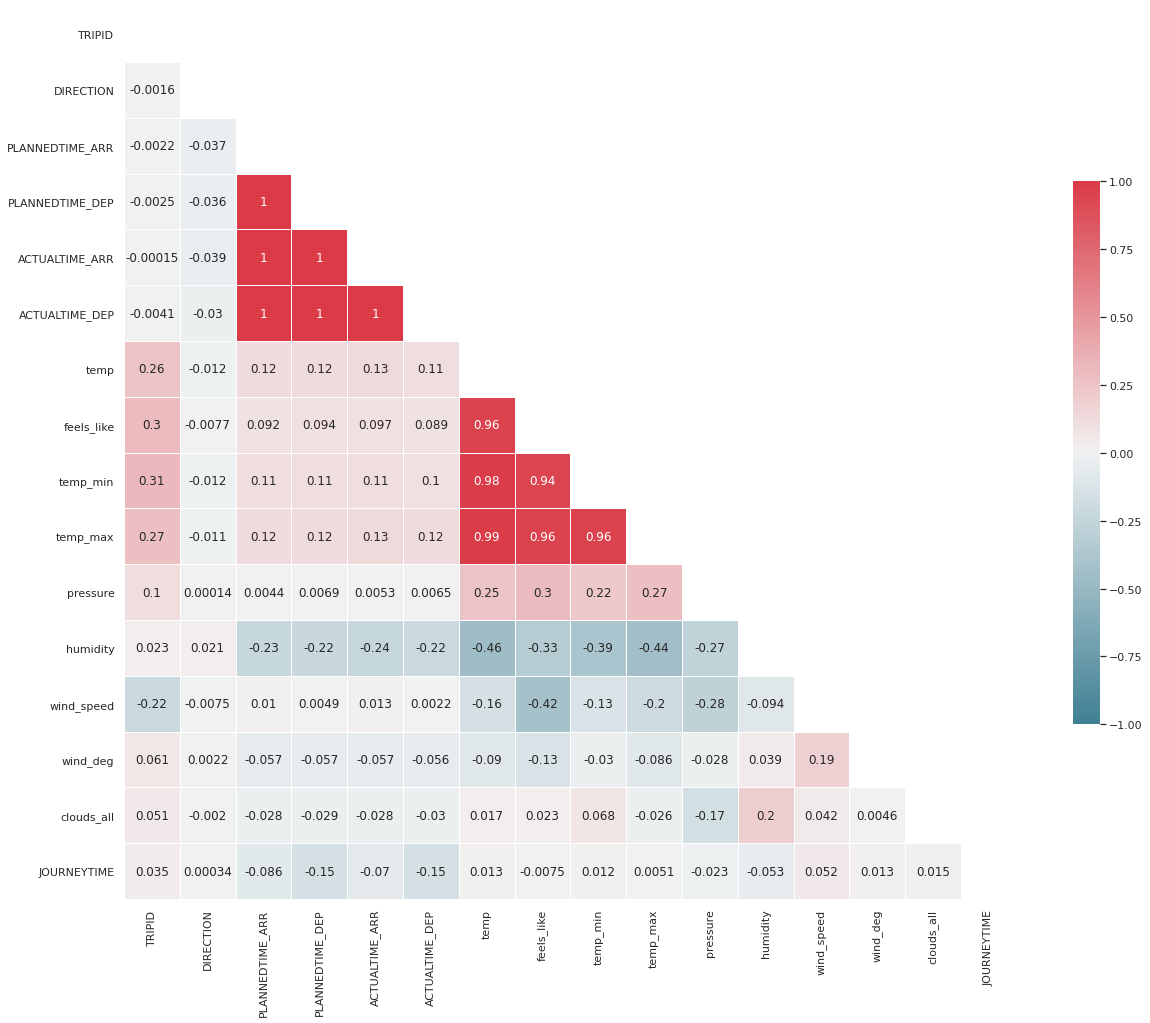

In [22]:
# Correlation matrix using code found on https://stanford.edu/~mwaskom/software/seaborn/examples/many_pairwise_correlations.html
sns.set(style="white")

# Calculate correlation of all pairs of continuous features
corr = merged.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom colormap - blue and red
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.yticks(rotation = 0)
plt.xticks(rotation = 90)

In [23]:
# Calculate pairwise correlation between JOURNEYTIME and numeric features
merged.corr()["JOURNEYTIME"]

TRIPID             0.034615
DIRECTION          0.000340
PLANNEDTIME_ARR   -0.085888
PLANNEDTIME_DEP   -0.151385
ACTUALTIME_ARR    -0.070341
ACTUALTIME_DEP    -0.151904
temp               0.012644
feels_like        -0.007463
temp_min           0.011890
temp_max           0.005134
pressure          -0.022684
humidity          -0.052586
wind_speed         0.052395
wind_deg           0.013141
clouds_all         0.014623
JOURNEYTIME        1.000000
Name: JOURNEYTIME, dtype: float64

<p>Examining the heat map and the pairwise correlation coefficients above we can see that there is no strong correlation between any of our numeric features and the target feature JOURNEYTIME. Next we will add time features to the dataframe to investigate whether JOURNEYTIME is affected by time of day, day of week or month of year. We will also add a precipitation feature to further explore whether precipitation has an effect on JOURNEYTIME.</p>

In [24]:
merged.weather_main.unique()

['Clouds', 'Drizzle', 'Rain', 'Fog', 'Mist', 'Clear', 'Snow', 'Smoke']
Categories (8, object): ['Clouds', 'Drizzle', 'Rain', 'Fog', 'Mist', 'Clear', 'Snow', 'Smoke']

In [25]:
# Create boolean precipitation feature
merged["precipitation_true"] = np.where((merged["weather_main"] == "Drizzle") | (merged["weather_main"] == "Rain") | (merged["weather_main"] == "Snow"), 1, 0)

In [26]:
merged.head()

,TRIPID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,dt,temp,...,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_main,JOURNEYTIME,precipitation_true
0,6253783,68,68_80,1,87245,84600,87524.0,84600.0,2018-02-07 23:00:00,5.44,...,4.06,6.00,1015,87,7.20,220,75,Clouds,2924.0,0
1,6262138,25B,25B_271,2,30517,26460,32752.0,NaN,2018-02-07 07:00:00,-1.60,...,-2.00,1.75,1023,93,5.14,270,20,Clouds,NaN,0
2,6254942,45A,45A_70,2,35512,32100,36329.0,32082.0,2018-02-07 08:00:00,-1.22,...,-2.00,1.77,1023,100,4.12,250,40,Clouds,4247.0,0
3,6259460,25A,25A_273,1,57261,54420,58463.0,54443.0,2018-02-07 15:00:00,3.55,...,2.93,4.21,1021,87,5.14,230,90,Drizzle,4020.0,1
4,6253175,14,14_15,1,85383,81600,84682.0,81608.0,2018-02-07 22:00:00,5.02,...,4.46,5.61,1016,87,8.75,230,75,Clouds,3074.0,0


<AxesSubplot:xlabel='precipitation_true', ylabel='JOURNEYTIME'>

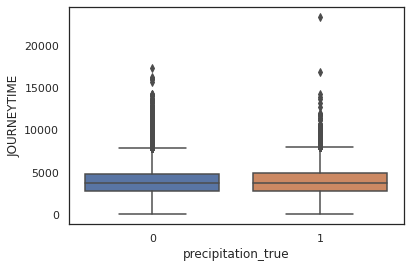

In [27]:
# Plot JOURNEYTIME precipitation vs no precipitation
sns.boxplot(x="precipitation_true", y="JOURNEYTIME", data=merged)

In [28]:
merged.head()

,TRIPID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,dt,temp,...,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_main,JOURNEYTIME,precipitation_true
0,6253783,68,68_80,1,87245,84600,87524.0,84600.0,2018-02-07 23:00:00,5.44,...,4.06,6.00,1015,87,7.20,220,75,Clouds,2924.0,0
1,6262138,25B,25B_271,2,30517,26460,32752.0,NaN,2018-02-07 07:00:00,-1.60,...,-2.00,1.75,1023,93,5.14,270,20,Clouds,NaN,0
2,6254942,45A,45A_70,2,35512,32100,36329.0,32082.0,2018-02-07 08:00:00,-1.22,...,-2.00,1.77,1023,100,4.12,250,40,Clouds,4247.0,0
3,6259460,25A,25A_273,1,57261,54420,58463.0,54443.0,2018-02-07 15:00:00,3.55,...,2.93,4.21,1021,87,5.14,230,90,Drizzle,4020.0,1
4,6253175,14,14_15,1,85383,81600,84682.0,81608.0,2018-02-07 22:00:00,5.02,...,4.46,5.61,1016,87,8.75,230,75,Clouds,3074.0,0


In [29]:
# Extract month, weekday and hour from datetime and add as features
merged["MONTH"] = merged["dt"].dt.month
merged["WEEKDAY"] = merged["dt"].dt.dayofweek
merged["HOUR"] = merged["dt"].dt.hour

In [30]:
month_list = merged.MONTH.unique().tolist()
month_list.sort()
print(month_list)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [31]:
# For consistency set Jan as month 0 etc.
merged["MONTH"] = merged["MONTH"] - 1

In [32]:
weekday_list = merged.WEEKDAY.unique().tolist()
weekday_list.sort()
print(weekday_list)

[0, 1, 2, 3, 4, 5, 6]


In [33]:
hour_list = merged.HOUR.unique().tolist()
hour_list.sort()
print(hour_list)

[0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [34]:
merged.drop(["dt"], axis=1, inplace=True)

In [35]:
merged.head()

,TRIPID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,temp,feels_like,...,humidity,wind_speed,wind_deg,clouds_all,weather_main,JOURNEYTIME,precipitation_true,MONTH,WEEKDAY,HOUR
0,6253783,68,68_80,1,87245,84600,87524.0,84600.0,5.44,-1.02,...,87,7.20,220,75,Clouds,2924.0,0,1,2,23
1,6262138,25B,25B_271,2,30517,26460,32752.0,NaN,-1.60,-7.53,...,93,5.14,270,20,Clouds,NaN,0,1,2,7
2,6254942,45A,45A_70,2,35512,32100,36329.0,32082.0,-1.22,-6.26,...,100,4.12,250,40,Clouds,4247.0,0,1,2,8
3,6259460,25A,25A_273,1,57261,54420,58463.0,54443.0,3.55,-1.79,...,87,5.14,230,90,Drizzle,4020.0,1,1,2,15
4,6253175,14,14_15,1,85383,81600,84682.0,81608.0,5.02,-2.60,...,87,8.75,230,75,Clouds,3074.0,0,1,2,22


In [36]:
# Create weekend vs weekday feature
merged["weekend_true"] = np.where(merged["WEEKDAY"] > 4, 1, 0)

In [37]:
# Create peak vs off-peak feature
merged["peak_true"] = 0
merged.loc[((merged["HOUR"] >= 6) & (merged["HOUR"] <= 10) & (merged["weekend_true"] == 0)) | ((merged["HOUR"] >= 16) & (merged["HOUR"] <= 19) & (merged["weekend_true"] == 0)), "peak_true"] = 1

In [38]:
merged.head()

,TRIPID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,temp,feels_like,...,wind_deg,clouds_all,weather_main,JOURNEYTIME,precipitation_true,MONTH,WEEKDAY,HOUR,weekend_true,peak_true
0,6253783,68,68_80,1,87245,84600,87524.0,84600.0,5.44,-1.02,...,220,75,Clouds,2924.0,0,1,2,23,0,0
1,6262138,25B,25B_271,2,30517,26460,32752.0,NaN,-1.60,-7.53,...,270,20,Clouds,NaN,0,1,2,7,0,1
2,6254942,45A,45A_70,2,35512,32100,36329.0,32082.0,-1.22,-6.26,...,250,40,Clouds,4247.0,0,1,2,8,0,1
3,6259460,25A,25A_273,1,57261,54420,58463.0,54443.0,3.55,-1.79,...,230,90,Drizzle,4020.0,1,1,2,15,0,0
4,6253175,14,14_15,1,85383,81600,84682.0,81608.0,5.02,-2.60,...,230,75,Clouds,3074.0,0,1,2,22,0,0


In [39]:
merged.columns

Index(['TRIPID', 'LINEID', 'ROUTEID', 'DIRECTION', 'PLANNEDTIME_ARR',
       'PLANNEDTIME_DEP', 'ACTUALTIME_ARR', 'ACTUALTIME_DEP', 'temp',
       'feels_like', 'temp_min', 'temp_max', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'clouds_all', 'weather_main', 'JOURNEYTIME',
       'precipitation_true', 'MONTH', 'WEEKDAY', 'HOUR', 'weekend_true',
       'peak_true'],
      dtype='object')

In [40]:
# Create subset for each new time-related feature
monday_sub = merged[merged["WEEKDAY"] == 0]
tuesday_sub = merged[merged["WEEKDAY"] == 1]
wednesday_sub = merged[merged["WEEKDAY"] == 2]
thursday_sub = merged[merged["WEEKDAY"] == 3]
friday_sub = merged[merged["WEEKDAY"] == 4]
saturday_sub = merged[merged["WEEKDAY"] == 5]
sunday_sub = merged[merged["WEEKDAY"] == 6]

weekend_true = merged[merged["weekend_true"] == 1]
weekend_false = merged[merged["weekend_true"] == 0]

jan_sub = merged[merged["MONTH"] == 0]
feb_sub = merged[merged["MONTH"] == 1]
mar_sub = merged[merged["MONTH"] == 2]
apr_sub = merged[merged["MONTH"] == 3]
may_sub = merged[merged["MONTH"] == 4]
jun_sub = merged[merged["MONTH"] == 5]
jul_sub = merged[merged["MONTH"] == 6]
aug_sub = merged[merged["MONTH"] == 7]
sept_sub = merged[merged["MONTH"] == 8]
oct_sub = merged[merged["MONTH"] == 9]
nov_sub = merged[merged["MONTH"] == 10]
dec_sub = merged[merged["MONTH"] == 11]

clouds_sub = merged[merged["weather_main"] == "Clouds"]
drizzle_sub = merged[merged["weather_main"] == "Drizzle"]
rain_sub = merged[merged["weather_main"] == "Rain"]
fog_sub = merged[merged["weather_main"] == "Fog"]
mist_sub = merged[merged["weather_main"] == "Mist"]
clear_sub = merged[merged["weather_main"] == "Clear"]
snow_sub = merged[merged["weather_main"] == "Snow"]
smoke_sub = merged[merged["weather_main"] == "Smoke"]

In [41]:
scatter_features = ["temp", "feels_like", "temp_min", "temp_max", "pressure", "humidity", "wind_speed", "wind_deg", "clouds_all"]

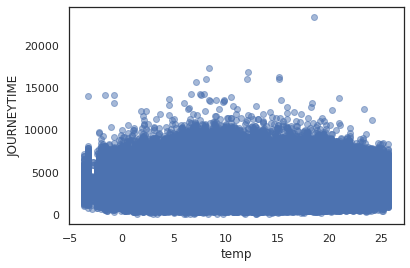

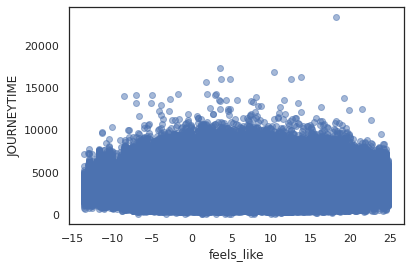

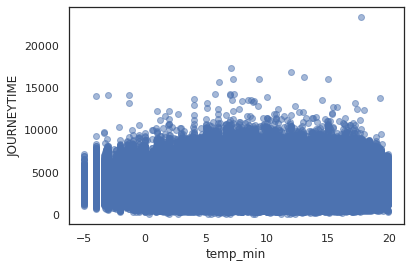

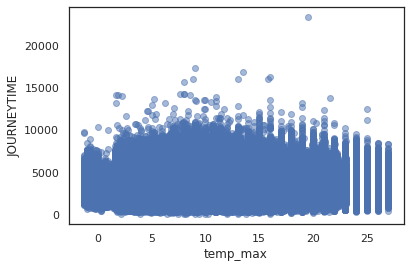

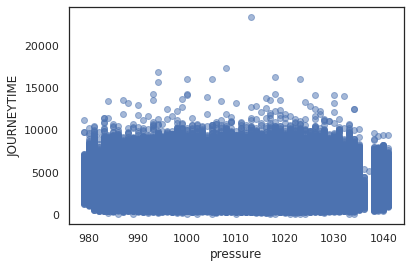

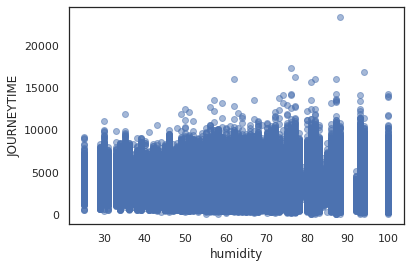

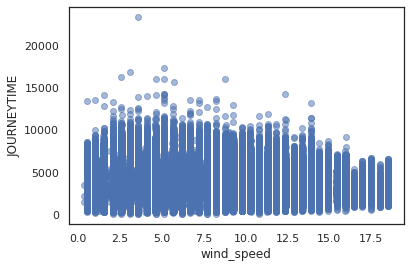

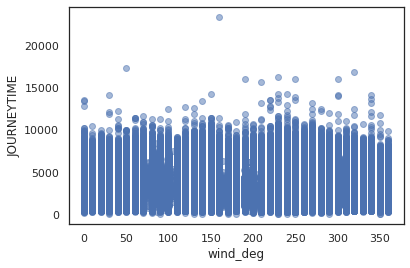

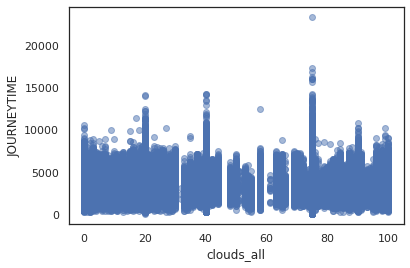

In [42]:
for feature in scatter_features:
    plt.scatter(merged[feature], merged.JOURNEYTIME, alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel("JOURNEYTIME")
    plt.show()

<p>Examining the scatter plots above we can see non-linear relationships between our independent numeric variable and our dependent variable JOURNEYTIME. A model suited to modelling non-linear relationships, such as random forest or neural networks will be necesssary.</p>

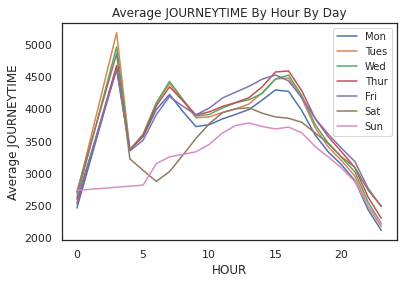

In [43]:
# Plot average JOURNEYTIME throughout the day for each weekday
monday_sub.groupby(["HOUR"])["JOURNEYTIME"].mean().plot()
tuesday_sub.groupby(["HOUR"])["JOURNEYTIME"].mean().plot()
wednesday_sub.groupby(["HOUR"])["JOURNEYTIME"].mean().plot()
thursday_sub.groupby(["HOUR"])["JOURNEYTIME"].mean().plot()
friday_sub.groupby(["HOUR"])["JOURNEYTIME"].mean().plot()
saturday_sub.groupby(["HOUR"])["JOURNEYTIME"].mean().plot()
sunday_sub.groupby(["HOUR"])["JOURNEYTIME"].mean().plot()

plt.title("Average JOURNEYTIME By Hour By Day")
plt.ylabel("Average JOURNEYTIME")
plt.legend(["Mon", "Tues", "Wed", "Thur", "Fri", "Sat", "Sun"], fontsize="small")
plt.show()

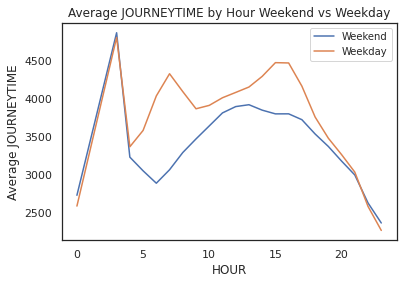

In [44]:
# Plot average JOURNEYTIME throughout the day weekend vs weekday
weekend_true.groupby(["HOUR"])["JOURNEYTIME"].mean().plot()
weekend_false.groupby(["HOUR"])["JOURNEYTIME"].mean().plot()

plt.title("Average JOURNEYTIME by Hour Weekend vs Weekday")
plt.ylabel("Average JOURNEYTIME")
plt.legend(["Weekend","Weekday"], fontsize="small")
plt.show()

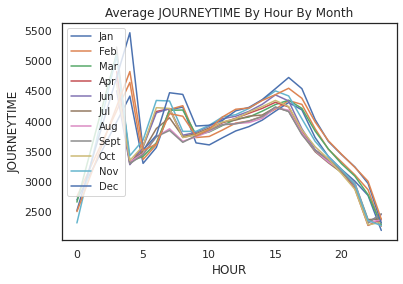

In [45]:
# Plot average JOURNEYTIME throughout the day for each month
jan_sub.groupby(["HOUR"])["JOURNEYTIME"].mean().plot()
feb_sub.groupby(["HOUR"])["JOURNEYTIME"].mean().plot()
mar_sub.groupby(["HOUR"])["JOURNEYTIME"].mean().plot()
apr_sub.groupby(["HOUR"])["JOURNEYTIME"].mean().plot()
may_sub.groupby(["HOUR"])["JOURNEYTIME"].mean().plot()
jun_sub.groupby(["HOUR"])["JOURNEYTIME"].mean().plot()
jul_sub.groupby(["HOUR"])["JOURNEYTIME"].mean().plot()
aug_sub.groupby(["HOUR"])["JOURNEYTIME"].mean().plot()
sept_sub.groupby(["HOUR"])["JOURNEYTIME"].mean().plot()
oct_sub.groupby(["HOUR"])["JOURNEYTIME"].mean().plot()
nov_sub.groupby(["HOUR"])["JOURNEYTIME"].mean().plot()
dec_sub.groupby(["HOUR"])["JOURNEYTIME"].mean().plot()

plt.title("Average JOURNEYTIME By Hour By Month")
plt.ylabel("JOURNEYTIME")
plt.legend(["Jan", "Feb", "Mar", "Apr", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"], fontsize="small")
plt.show()

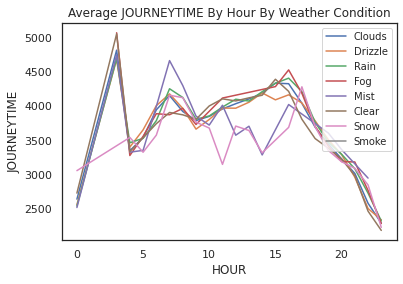

In [46]:
clouds_sub.groupby(["HOUR"])["JOURNEYTIME"].mean().plot()
drizzle_sub.groupby(["HOUR"])["JOURNEYTIME"].mean().plot()
rain_sub.groupby(["HOUR"])["JOURNEYTIME"].mean().plot()
fog_sub.groupby(["HOUR"])["JOURNEYTIME"].mean().plot()
mist_sub.groupby(["HOUR"])["JOURNEYTIME"].mean().plot()
clear_sub.groupby(["HOUR"])["JOURNEYTIME"].mean().plot()
snow_sub.groupby(["HOUR"])["JOURNEYTIME"].mean().plot()
smoke_sub.groupby(["HOUR"])["JOURNEYTIME"].mean().plot()

plt.title("Average JOURNEYTIME By Hour By Weather Condition")
plt.ylabel("JOURNEYTIME")
plt.legend(["Clouds", "Drizzle", "Rain", "Fog", "Mist", "Clear", "Snow", "Smoke"], fontsize="small")
plt.show()

<AxesSubplot:xlabel='HOUR', ylabel='JOURNEYTIME'>

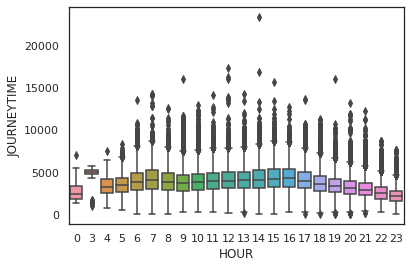

In [47]:
# Plot JOURNEYTIME by hour
sns.boxplot(x="HOUR", y="JOURNEYTIME", data=merged)

<AxesSubplot:xlabel='peak_true', ylabel='JOURNEYTIME'>

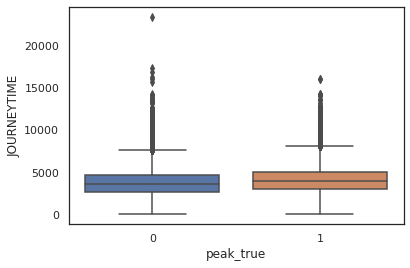

In [48]:
# Plot JOURNEYTIME peak vs off-peak (morning and evening rush hour)
sns.boxplot(x="peak_true", y="JOURNEYTIME", data=merged)

<AxesSubplot:xlabel='WEEKDAY', ylabel='JOURNEYTIME'>

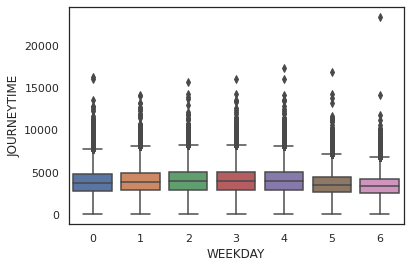

In [49]:
# Plot JOURNEYTIME per weekday
sns.boxplot(x="WEEKDAY", y="JOURNEYTIME", data=merged)

<AxesSubplot:xlabel='weekend_true', ylabel='JOURNEYTIME'>

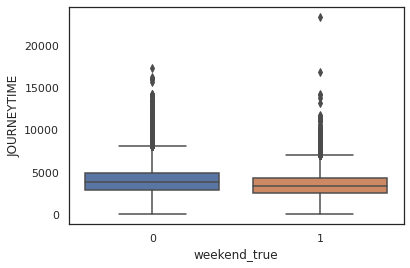

In [50]:
# Plot JOURNEYTIME weekend vs weekday
sns.boxplot(x="weekend_true", y="JOURNEYTIME", data=merged)

<AxesSubplot:xlabel='MONTH', ylabel='JOURNEYTIME'>

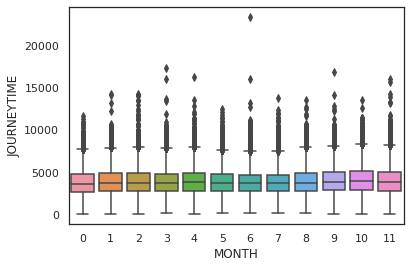

In [51]:
# Plot JOURNEYTIME per month
sns.boxplot(x="MONTH", y="JOURNEYTIME", data=merged)

<p>Examining the above plots we can see that average JOURNEYTIME fluctuates throughout the day, peaking at peak hours i.e. morning and evening rush hours for weekdays, and assuming a different yet consistent pattern for weekend days. HOUR will therefore be retained as a potentially useful feature. We can also see that JOURNEYTIME throughout the day varies depending on the day of the week and in particular for WEEKEND vs WEEKDAY (weekend_true 1 and 0); WEEKDAY and weekend_true will also be retained. Hourly JOURNEYTIME when averaged for each month appears similar accross all months. MONTH therefore may be dropped. However, our boxplots are dominated by newly introduced outliers in our derived JOURNEYTIME feature and these outliers will be removed and the boxplots repeated before features are dropped, including revaluating whether our precipitation feature has an impact on JOURNEYTIME. It is difficult to explain the peak in JOURNEYTIME between the hours of 3 and 4am - hopefully this will become clear following further exploration. All weather features will be retained for now despite showing little correlation with the target feature.</p>

<h4>Create dummies for categorical variables</h4>

In [52]:
merged.columns

Index(['TRIPID', 'LINEID', 'ROUTEID', 'DIRECTION', 'PLANNEDTIME_ARR',
       'PLANNEDTIME_DEP', 'ACTUALTIME_ARR', 'ACTUALTIME_DEP', 'temp',
       'feels_like', 'temp_min', 'temp_max', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'clouds_all', 'weather_main', 'JOURNEYTIME',
       'precipitation_true', 'MONTH', 'WEEKDAY', 'HOUR', 'weekend_true',
       'peak_true'],
      dtype='object')

<p>TRIPID can be dropped as it is of no use to us here.</p>

In [53]:
merged.drop(["TRIPID"], axis = 1, inplace=True)

In [54]:
# Create LINEID and ROUTEID lists to be added back in after dummies are added
# These features will be needed to split the data for modelling
LINEID_list = merged.LINEID.tolist()
ROUTEID_list = merged.ROUTEID.tolist()

In [55]:
merged.dtypes

LINEID                  object
ROUTEID                 object
DIRECTION                int64
PLANNEDTIME_ARR          int64
PLANNEDTIME_DEP          int64
ACTUALTIME_ARR         float64
ACTUALTIME_DEP         float64
temp                   float64
feels_like             float64
temp_min               float64
temp_max               float64
pressure                 int64
humidity                 int64
wind_speed             float64
wind_deg                 int64
clouds_all               int64
weather_main          category
JOURNEYTIME            float64
precipitation_true       int64
MONTH                    int64
WEEKDAY                  int64
HOUR                     int64
weekend_true             int64
peak_true                int64
dtype: object

In [56]:
cat_features = ["weather_main", "precipitation_true", "MONTH", "WEEKDAY", "HOUR", "weekend_true", "peak_true"]

for feature in cat_features:
    merged[feature] = merged[feature].astype("category")

In [57]:
continuous_columns = merged.select_dtypes(["int64", "float64"]).columns
category_columns = merged.select_dtypes(["category"]).columns

In [58]:
continuous_columns

Index(['DIRECTION', 'PLANNEDTIME_ARR', 'PLANNEDTIME_DEP', 'ACTUALTIME_ARR',
       'ACTUALTIME_DEP', 'temp', 'feels_like', 'temp_min', 'temp_max',
       'pressure', 'humidity', 'wind_speed', 'wind_deg', 'clouds_all',
       'JOURNEYTIME'],
      dtype='object')

In [59]:
category_columns

Index(['weather_main', 'precipitation_true', 'MONTH', 'WEEKDAY', 'HOUR',
       'weekend_true', 'peak_true'],
      dtype='object')

In [60]:
df_cont = merged[continuous_columns]
df_cont.head()

,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,JOURNEYTIME
0,1,87245,84600,87524.0,84600.0,5.44,-1.02,4.06,6.00,1015,87,7.20,220,75,2924.0
1,2,30517,26460,32752.0,NaN,-1.60,-7.53,-2.00,1.75,1023,93,5.14,270,20,NaN
2,2,35512,32100,36329.0,32082.0,-1.22,-6.26,-2.00,1.77,1023,100,4.12,250,40,4247.0
3,1,57261,54420,58463.0,54443.0,3.55,-1.79,2.93,4.21,1021,87,5.14,230,90,4020.0
4,1,85383,81600,84682.0,81608.0,5.02,-2.60,4.46,5.61,1016,87,8.75,230,75,3074.0


In [61]:
df_cat = merged[category_columns]
df_cat.head()

,weather_main,precipitation_true,MONTH,WEEKDAY,HOUR,weekend_true,peak_true
0,Clouds,0,1,2,23,0,0
1,Clouds,0,1,2,7,0,1
2,Clouds,0,1,2,8,0,1
3,Drizzle,1,1,2,15,0,0
4,Clouds,0,1,2,22,0,0


In [62]:
df_cat = pd.get_dummies(df_cat, drop_first=True)

In [63]:
df_cat.head()

,weather_main_Clouds,weather_main_Drizzle,weather_main_Fog,weather_main_Mist,weather_main_Rain,weather_main_Smoke,weather_main_Snow,precipitation_true_1,MONTH_1,MONTH_2,...,HOUR_16,HOUR_17,HOUR_18,HOUR_19,HOUR_20,HOUR_21,HOUR_22,HOUR_23,weekend_true_1,peak_true_1
0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [64]:
merged_with_dummies = df_cont.join(df_cat)
merged_with_dummies.head()

,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,temp,feels_like,temp_min,temp_max,pressure,...,HOUR_16,HOUR_17,HOUR_18,HOUR_19,HOUR_20,HOUR_21,HOUR_22,HOUR_23,weekend_true_1,peak_true_1
0,1,87245,84600,87524.0,84600.0,5.44,-1.02,4.06,6.00,1015,...,0,0,0,0,0,0,0,1,0,0
1,2,30517,26460,32752.0,NaN,-1.60,-7.53,-2.00,1.75,1023,...,0,0,0,0,0,0,0,0,0,1
2,2,35512,32100,36329.0,32082.0,-1.22,-6.26,-2.00,1.77,1023,...,0,0,0,0,0,0,0,0,0,1
3,1,57261,54420,58463.0,54443.0,3.55,-1.79,2.93,4.21,1021,...,0,0,0,0,0,0,0,0,0,0
4,1,85383,81600,84682.0,81608.0,5.02,-2.60,4.46,5.61,1016,...,0,0,0,0,0,0,1,0,0,0


In [65]:
# Reinsert LINEID and ROUTEID
merged_with_dummies.insert(loc=0, column="ROUTEID", value=ROUTEID_list)
merged_with_dummies.insert(loc=0, column="LINEID", value=LINEID_list)

In [66]:
merged_with_dummies.dtypes

LINEID             object
ROUTEID            object
DIRECTION           int64
PLANNEDTIME_ARR     int64
PLANNEDTIME_DEP     int64
                    ...  
HOUR_21             uint8
HOUR_22             uint8
HOUR_23             uint8
weekend_true_1      uint8
peak_true_1         uint8
Length: 65, dtype: object

In [67]:
merged_with_dummies.columns

Index(['LINEID', 'ROUTEID', 'DIRECTION', 'PLANNEDTIME_ARR', 'PLANNEDTIME_DEP',
       'ACTUALTIME_ARR', 'ACTUALTIME_DEP', 'temp', 'feels_like', 'temp_min',
       'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg',
       'clouds_all', 'JOURNEYTIME', 'weather_main_Clouds',
       'weather_main_Drizzle', 'weather_main_Fog', 'weather_main_Mist',
       'weather_main_Rain', 'weather_main_Smoke', 'weather_main_Snow',
       'precipitation_true_1', 'MONTH_1', 'MONTH_2', 'MONTH_3', 'MONTH_4',
       'MONTH_5', 'MONTH_6', 'MONTH_7', 'MONTH_8', 'MONTH_9', 'MONTH_10',
       'MONTH_11', 'WEEKDAY_1', 'WEEKDAY_2', 'WEEKDAY_3', 'WEEKDAY_4',
       'WEEKDAY_5', 'WEEKDAY_6', 'HOUR_3', 'HOUR_4', 'HOUR_5', 'HOUR_6',
       'HOUR_7', 'HOUR_8', 'HOUR_9', 'HOUR_10', 'HOUR_11', 'HOUR_12',
       'HOUR_13', 'HOUR_14', 'HOUR_15', 'HOUR_16', 'HOUR_17', 'HOUR_18',
       'HOUR_19', 'HOUR_20', 'HOUR_21', 'HOUR_22', 'HOUR_23', 'weekend_true_1',
       'peak_true_1'],
      dtype='object')

<h4>Carry out MissForest imputation for remaining nulls for ACTUALTIME_ARR and ACTUALTIME_DEP for most common subroutes</h4>

In [68]:
with open("most_common_subroutes.txt") as file:
    most_common_subroutes = file.readlines()
most_common_subroutes = [line.strip() for line in most_common_subroutes] 

In [69]:
len(most_common_subroutes)

252

In [70]:
merged_with_dummies.drop(["JOURNEYTIME"], axis=1, inplace=True)

In [71]:
# Add missing hours
merged_with_dummies["HOUR_1"] = 0
merged_with_dummies["HOUR_1"] = merged_with_dummies["HOUR_1"].astype("uint8")

merged_with_dummies["HOUR_2"] = 0
merged_with_dummies["HOUR_2"] = merged_with_dummies["HOUR_2"].astype("uint8")

In [72]:
orig_data = merged_with_dummies.copy()

In [73]:
final = pd.DataFrame(columns=merged_with_dummies.columns)
final.head()

,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,temp,feels_like,temp_min,...,HOUR_18,HOUR_19,HOUR_20,HOUR_21,HOUR_22,HOUR_23,weekend_true_1,peak_true_1,HOUR_1,HOUR_2


In [74]:
# Impute missing values using MissForest imputer
for route in most_common_subroutes:
    temp = merged_with_dummies.loc[(merged_with_dummies["ROUTEID"] == route)]
    direction = temp.iloc[0]["DIRECTION"]
    temp.drop(["LINEID", "ROUTEID", "DIRECTION"], axis=1, inplace=True)
    
    imputer = MissForest(random_state=1)
    temp_imputed = imputer.fit_transform(temp)
    
    temp["ACTUALTIME_ARR"] = temp_imputed[:, 2]
    temp["ACTUALTIME_DEP"] = temp_imputed[:, 3]
    
    temp.insert(loc=0, column="DIRECTION", value=direction)
    temp.insert(loc=0, column="ROUTEID", value=route)
    temp.insert(loc=0, column="LINEID", value=route.split("_")[0])
    
    final = final.append(temp, ignore_index=True)
    print("Imputation complete for route", route)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Imputation complete for route 102_8
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Imputation complete for route 102_9
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Imputation complete for route 104_15
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Imputation complete for route 104_16
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Imputation complete for route 111_7
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Imputation complete for route 111_8
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Imputation complete for route 114_5
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Imputation complete for route 114_6
Iteration: 0
Iteration: 1
Iteration: 2
Imputation complete f

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Imputation complete for route 25X_10
Iteration: 0
Iteration: 1
Iteration: 2
Imputation complete for route 25X_11
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Imputation complete for route 25_269
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Imputation complete for route 25_272
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Imputation complete for route 26_28
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Imputation complete for route 26_29
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Imputation complete for route 270_42
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Imputation complete for route 270_44
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Imputation complete for route 

Iteration: 5
Imputation complete for route 42_44
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Imputation complete for route 43_84
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Imputation complete for route 43_88
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Imputation complete for route 44B_60
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Imputation complete for route 44B_61
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Imputation complete for route 44_36
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Imputation complete for route 44_40
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Imputation complete for route 45A_60
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Imputation complete for route 45A_64
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Imputatio

Iteration: 5
Iteration: 6
Iteration: 7
Imputation complete for route 7A_87
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Imputation complete for route 7B_91
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Imputation complete for route 7B_93
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Imputation complete for route 7D_120
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Imputation complete for route 7D_123
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Imputation complete for route 7_70
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Imputation complete for route 7_72
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Imputation complete for route 83A_17
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Imputation complete for route 83A_23
Iteration: 0
Iteration: 

In [75]:
final.head()

,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,temp,feels_like,temp_min,...,HOUR_18,HOUR_19,HOUR_20,HOUR_21,HOUR_22,HOUR_23,weekend_true_1,peak_true_1,HOUR_1,HOUR_2
0,102,102_8,1,66720,63300,66668.0,63277.0,9.81,5.49,8.69,...,0,0,0,0,0,0,1,0,0,0
1,102,102_8,1,56520,53100,56752.0,53093.0,9.26,6.32,8.24,...,0,0,0,0,0,0,1,0,0,0
2,102,102_8,1,62520,59100,62673.0,59183.0,9.76,5.50,8.43,...,0,0,0,0,0,0,1,0,0,0
3,102,102_8,1,49038,45300,49075.0,45275.0,19.39,17.97,16.71,...,0,0,0,0,0,0,0,0,0,0
4,102,102_8,1,31494,28200,31799.0,28217.0,13.93,14.14,13.00,...,0,0,0,0,0,0,0,1,0,0


In [76]:
final.to_csv("missforestimputed.csv", index=False)

In [77]:
final = pd.read_csv("missforestimputed.csv")

In [78]:
final.head()

,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,temp,feels_like,temp_min,...,HOUR_18,HOUR_19,HOUR_20,HOUR_21,HOUR_22,HOUR_23,weekend_true_1,peak_true_1,HOUR_1,HOUR_2
0,102,102_8,1,66720,63300,66668.0,63277.0,9.81,5.49,8.69,...,0,0,0,0,0,0,1,0,0,0
1,102,102_8,1,56520,53100,56752.0,53093.0,9.26,6.32,8.24,...,0,0,0,0,0,0,1,0,0,0
2,102,102_8,1,62520,59100,62673.0,59183.0,9.76,5.50,8.43,...,0,0,0,0,0,0,1,0,0,0
3,102,102_8,1,49038,45300,49075.0,45275.0,19.39,17.97,16.71,...,0,0,0,0,0,0,0,0,0,0
4,102,102_8,1,31494,28200,31799.0,28217.0,13.93,14.14,13.00,...,0,0,0,0,0,0,0,1,0,0


In [79]:
final.shape

(1874210, 66)

In [80]:
pd.set_option("display.max_rows", 70)
final.isna().sum()

LINEID                  0
ROUTEID                 0
DIRECTION               0
PLANNEDTIME_ARR         0
PLANNEDTIME_DEP         0
ACTUALTIME_ARR          0
ACTUALTIME_DEP          0
temp                    0
feels_like              0
temp_min                0
temp_max                0
pressure                0
humidity                0
wind_speed              0
wind_deg                0
clouds_all              0
weather_main_Clouds     0
weather_main_Drizzle    0
weather_main_Fog        0
weather_main_Mist       0
weather_main_Rain       0
weather_main_Smoke      0
weather_main_Snow       0
precipitation_true_1    0
MONTH_1                 0
MONTH_2                 0
MONTH_3                 0
MONTH_4                 0
MONTH_5                 0
MONTH_6                 0
MONTH_7                 0
MONTH_8                 0
MONTH_9                 0
MONTH_10                0
MONTH_11                0
WEEKDAY_1               0
WEEKDAY_2               0
WEEKDAY_3               0
WEEKDAY_4   

In [81]:
final["ACTUALTIME_ARR"] = final["ACTUALTIME_ARR"].astype("int64")
final["ACTUALTIME_DEP"] = final["ACTUALTIME_DEP"].astype("int64")

In [82]:
# Repeat logical integrity check for entries where ACTUALTIME_ARR precedes ACTUALTIME_DEP following imputation
test1 = final.loc[final["ACTUALTIME_ARR"] < final["ACTUALTIME_DEP"]]

In [83]:
# Delete these entries
test1_indices = final[final["ACTUALTIME_ARR"] < final["ACTUALTIME_DEP"]].index

In [84]:
len(test1_indices.tolist())

54

In [85]:
final.drop(test1_indices, inplace=True)

In [86]:
print("Number of entries remaining in RT_TRIPS:", final.shape[0])

Number of entries remaining in RT_TRIPS: 1874156


<h4>Create JOURNEYTIME target feature and explore range of values per route for JOURNEYTIME</h4>

In [87]:
# Create JOURNEYTIME feature, our target feature
final["JOURNEYTIME"] = final["ACTUALTIME_ARR"] - final["ACTUALTIME_DEP"]

In [88]:
final.head()

,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,temp,feels_like,temp_min,...,HOUR_19,HOUR_20,HOUR_21,HOUR_22,HOUR_23,weekend_true_1,peak_true_1,HOUR_1,HOUR_2,JOURNEYTIME
0,102,102_8,1,66720,63300,66668,63277,9.81,5.49,8.69,...,0,0,0,0,0,1,0,0,0,3391
1,102,102_8,1,56520,53100,56752,53093,9.26,6.32,8.24,...,0,0,0,0,0,1,0,0,0,3659
2,102,102_8,1,62520,59100,62673,59183,9.76,5.50,8.43,...,0,0,0,0,0,1,0,0,0,3490
3,102,102_8,1,49038,45300,49075,45275,19.39,17.97,16.71,...,0,0,0,0,0,0,0,0,0,3800
4,102,102_8,1,31494,28200,31799,28217,13.93,14.14,13.00,...,0,0,0,0,0,0,1,0,0,3582


In [89]:
final.columns

Index(['LINEID', 'ROUTEID', 'DIRECTION', 'PLANNEDTIME_ARR', 'PLANNEDTIME_DEP',
       'ACTUALTIME_ARR', 'ACTUALTIME_DEP', 'temp', 'feels_like', 'temp_min',
       'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg',
       'clouds_all', 'weather_main_Clouds', 'weather_main_Drizzle',
       'weather_main_Fog', 'weather_main_Mist', 'weather_main_Rain',
       'weather_main_Smoke', 'weather_main_Snow', 'precipitation_true_1',
       'MONTH_1', 'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6',
       'MONTH_7', 'MONTH_8', 'MONTH_9', 'MONTH_10', 'MONTH_11', 'WEEKDAY_1',
       'WEEKDAY_2', 'WEEKDAY_3', 'WEEKDAY_4', 'WEEKDAY_5', 'WEEKDAY_6',
       'HOUR_3', 'HOUR_4', 'HOUR_5', 'HOUR_6', 'HOUR_7', 'HOUR_8', 'HOUR_9',
       'HOUR_10', 'HOUR_11', 'HOUR_12', 'HOUR_13', 'HOUR_14', 'HOUR_15',
       'HOUR_16', 'HOUR_17', 'HOUR_18', 'HOUR_19', 'HOUR_20', 'HOUR_21',
       'HOUR_22', 'HOUR_23', 'weekend_true_1', 'peak_true_1', 'HOUR_1',
       'HOUR_2', 'JOURNEYTIME'],
      dtype='o

In [90]:
pd.set_option('display.max_rows', 70)
final.dtypes

LINEID                   object
ROUTEID                  object
DIRECTION                 int64
PLANNEDTIME_ARR           int64
PLANNEDTIME_DEP           int64
ACTUALTIME_ARR            int64
ACTUALTIME_DEP            int64
temp                    float64
feels_like              float64
temp_min                float64
temp_max                float64
pressure                  int64
humidity                  int64
wind_speed              float64
wind_deg                  int64
clouds_all                int64
weather_main_Clouds       int64
weather_main_Drizzle      int64
weather_main_Fog          int64
weather_main_Mist         int64
weather_main_Rain         int64
weather_main_Smoke        int64
weather_main_Snow         int64
precipitation_true_1      int64
MONTH_1                   int64
MONTH_2                   int64
MONTH_3                   int64
MONTH_4                   int64
MONTH_5                   int64
MONTH_6                   int64
MONTH_7                   int64
MONTH_8 

In [91]:
int_features = ["PLANNEDTIME_ARR", "PLANNEDTIME_DEP", "ACTUALTIME_ARR", "ACTUALTIME_DEP", "pressure", "humidity", "wind_deg", "clouds_all", "JOURNEYTIME"]

for feature in int_features:
    final[feature] = final[feature].astype("int64")
    
cat_features = ["weather_main_Clouds", "weather_main_Drizzle", "weather_main_Fog", "weather_main_Mist", "weather_main_Rain", "weather_main_Smoke", "weather_main_Snow", "MONTH_1", "MONTH_2", "MONTH_3", "MONTH_4", "MONTH_5", "MONTH_6", "MONTH_7", "MONTH_8", "MONTH_9", "MONTH_10", "MONTH_11", "WEEKDAY_1", "WEEKDAY_2", "WEEKDAY_3", "WEEKDAY_4", "WEEKDAY_5", "WEEKDAY_6", "HOUR_1", "HOUR_2", "HOUR_3", "HOUR_4", "HOUR_5", "HOUR_6", "HOUR_7", "HOUR_8", "HOUR_9", "HOUR_10", "HOUR_11", "HOUR_12", "HOUR_13", "HOUR_14", "HOUR_15", "HOUR_16", "HOUR_17", "HOUR_18", "HOUR_19", "HOUR_20", "HOUR_21", "HOUR_22", "HOUR_23", "precipitation_true_1", "weekend_true_1", "peak_true_1"]

for feature in cat_features:
    final[feature] = final[feature].astype("uint8")

In [92]:
final.loc[final["JOURNEYTIME"] < 0]

,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,temp,feels_like,temp_min,...,HOUR_19,HOUR_20,HOUR_21,HOUR_22,HOUR_23,weekend_true_1,peak_true_1,HOUR_1,HOUR_2,JOURNEYTIME


In [93]:
final_routes = final.ROUTEID.unique().tolist()
final_routes.sort()

In [94]:
most_common_subroutes.sort()

In [95]:
most_common_subroutes == final_routes

True

In [30]:
final.to_csv("trips_imputed_all_features.csv", index=False)

<h4>Remove outliers</h4>
<p>When the JOURNEYTIME feature was introduced earlier we saw that this feature contained many outliers. These outliers will now be removed; as our intention is to accurately predict average JOURNEYTIME retaining these entries which will add variation to our data is of no benefit to us in this situation.</p>

In [96]:
def min_max_per_route(df, route_list):
    for route in route_list:
        print("Route", route)
        current = df.loc[df["ROUTEID"] == route]
        print("Max JOURNEYTIME:", current.JOURNEYTIME.max())
        print("Min JOURNEYTIME:", current.JOURNEYTIME.min())
        print("**************************************")

In [97]:
min_max_per_route(final, final_routes)

Route 102_8
Max JOURNEYTIME: 8493
Min JOURNEYTIME: 1656
**************************************
Route 102_9
Max JOURNEYTIME: 7341
Min JOURNEYTIME: 1200
**************************************
Route 104_15
Max JOURNEYTIME: 5144
Min JOURNEYTIME: 972
**************************************
Route 104_16
Max JOURNEYTIME: 5286
Min JOURNEYTIME: 597
**************************************
Route 111_7
Max JOURNEYTIME: 5691
Min JOURNEYTIME: 1247
**************************************
Route 111_8
Max JOURNEYTIME: 10783
Min JOURNEYTIME: 77
**************************************
Route 114_5
Max JOURNEYTIME: 5056
Min JOURNEYTIME: 996
**************************************
Route 114_6
Max JOURNEYTIME: 8273
Min JOURNEYTIME: 535
**************************************
Route 116_1
Max JOURNEYTIME: 4878
Min JOURNEYTIME: 2221
**************************************
Route 116_3
Max JOURNEYTIME: 7599
Min JOURNEYTIME: 4272
**************************************
Route 118_4
Max JOURNEYTIME: 5480
Min JOURNEYTIME: 27

Max JOURNEYTIME: 4854
Min JOURNEYTIME: 175
**************************************
Route 27B_23
Max JOURNEYTIME: 6543
Min JOURNEYTIME: 476
**************************************
Route 27B_34
Max JOURNEYTIME: 6540
Min JOURNEYTIME: 410
**************************************
Route 27X_42
Max JOURNEYTIME: 5667
Min JOURNEYTIME: 3098
**************************************
Route 27X_43
Max JOURNEYTIME: 7059
Min JOURNEYTIME: 2696
**************************************
Route 27_17
Max JOURNEYTIME: 11668
Min JOURNEYTIME: 2022
**************************************
Route 27_19
Max JOURNEYTIME: 13502
Min JOURNEYTIME: 458
**************************************
Route 29A_14
Max JOURNEYTIME: 6430
Min JOURNEYTIME: 1277
**************************************
Route 29A_15
Max JOURNEYTIME: 9073
Min JOURNEYTIME: 1101
**************************************
Route 31A_25
Max JOURNEYTIME: 6379
Min JOURNEYTIME: 1367
**************************************
Route 31A_26
Max JOURNEYTIME: 6356
Min JOURNEYTIME: 1366


Max JOURNEYTIME: 10526
Min JOURNEYTIME: 303
**************************************
Route 51D_50
Max JOURNEYTIME: 4476
Min JOURNEYTIME: 2728
**************************************
Route 51D_51
Max JOURNEYTIME: 8448
Min JOURNEYTIME: 3424
**************************************
Route 51X_64
Max JOURNEYTIME: 6627
Min JOURNEYTIME: 3897
**************************************
Route 53_20
Max JOURNEYTIME: 5989
Min JOURNEYTIME: 878
**************************************
Route 53_21
Max JOURNEYTIME: 4787
Min JOURNEYTIME: 501
**************************************
Route 54A_11
Max JOURNEYTIME: 8442
Min JOURNEYTIME: 34
**************************************
Route 54A_12
Max JOURNEYTIME: 9464
Min JOURNEYTIME: 1712
**************************************
Route 56A_30
Max JOURNEYTIME: 7604
Min JOURNEYTIME: 1739
**************************************
Route 56A_31
Max JOURNEYTIME: 9444
Min JOURNEYTIME: 873
**************************************
Route 59_10
Max JOURNEYTIME: 8546
Min JOURNEYTIME: 550
*****

In [98]:
def interquartile_range_values(df, feature_name):
    '''Accepts dataframe and feature name; returns values for median, q1, q3, iqr and min and max values excluding outliers for that feature'''
    median = df[feature_name].median()
    
    q1 = df[feature_name].quantile(0.25)
    q3 = df[feature_name].quantile(0.75)
    iqr = q3-q1
    
    minimum = q1 - 1.5 * iqr
    maximum = q3 + 1.5 * iqr
    return median, q1, q3, iqr, minimum, maximum

In [99]:
median, q1, q3, iqr, minimum, maximum = interquartile_range_values(final, "JOURNEYTIME")

In [100]:
# These values are overall, to remove outliers we will calculate these values per route
print("JOURNEYTIME")
print("Median", median)
print("1st quartile", q1)
print("3rd quartile", q3)
print("Minimum", minimum)
print("Maximum", maximum)

JOURNEYTIME
Median 3837.0
1st quartile 2859.0
3rd quartile 4899.0
Minimum -201.0
Maximum 7959.0


In [101]:
def delete_outliers_per_route(df, feature_name, route_list):
    '''Accepts dataframe, feature name and route list; returns datframe with entries containing outlier for named feature removed, and count of entries removed'''
    cleaned_df = pd.DataFrame(columns=df.columns)
    total_entries_removed = 0
    for route in route_list:
        route_df = df.loc[df["ROUTEID"] == route]
        
        print("Number of entries for route", route + ":", route_df.shape[0])
        
        route_median, route_q1, route_q3, route_iqr, route_minimum, route_maximum = interquartile_range_values(route_df, feature_name)
        
        route_df["OUTLIER"] = np.where((route_df[feature_name] < route_minimum) | (route_df[feature_name] > route_maximum), 1, 0)
        num_outliers = np.sum(route_df["OUTLIER"] == 1)
        
        route_df.drop(route_df[route_df["OUTLIER"] == 1].index, inplace=True)
        cleaned_df = cleaned_df.append(route_df)
        
        print("Number of entries following removal of outliers:", route_df.shape[0])
        print("***************************************************")
        
        total_entries_removed += num_outliers
    return cleaned_df, total_entries_removed  

In [102]:
final_updated, num_entries_removed = delete_outliers_per_route(final, "JOURNEYTIME", final_routes)

Number of entries for route 102_8: 9440
Number of entries following removal of outliers: 9305
***************************************************
Number of entries for route 102_9: 9119
Number of entries following removal of outliers: 9052
***************************************************
Number of entries for route 104_15: 3803
Number of entries following removal of outliers: 3651
***************************************************
Number of entries for route 104_16: 3806
Number of entries following removal of outliers: 3556
***************************************************
Number of entries for route 111_7: 3988
Number of entries following removal of outliers: 3975
***************************************************
Number of entries for route 111_8: 2882
Number of entries following removal of outliers: 2877
***************************************************
Number of entries for route 114_5: 4957
Number of entries following removal of outliers: 4780
****************************

Number of entries following removal of outliers: 6902
***************************************************
Number of entries for route 184_29: 7705
Number of entries following removal of outliers: 7579
***************************************************
Number of entries for route 185_53: 2076
Number of entries following removal of outliers: 2015
***************************************************
Number of entries for route 185_56: 3581
Number of entries following removal of outliers: 3422
***************************************************
Number of entries for route 18_3: 8427
Number of entries following removal of outliers: 8233
***************************************************
Number of entries for route 18_4: 12974
Number of entries following removal of outliers: 12824
***************************************************
Number of entries for route 1_37: 14531
Number of entries following removal of outliers: 14352
***************************************************
Number of entr

Number of entries following removal of outliers: 131
***************************************************
Number of entries for route 33D_62: 103
Number of entries following removal of outliers: 101
***************************************************
Number of entries for route 33E_74: 14
Number of entries following removal of outliers: 14
***************************************************
Number of entries for route 33X_46: 981
Number of entries following removal of outliers: 953
***************************************************
Number of entries for route 33X_49: 1047
Number of entries following removal of outliers: 1010
***************************************************
Number of entries for route 33_44: 4456
Number of entries following removal of outliers: 4262
***************************************************
Number of entries for route 33_70: 4234
Number of entries following removal of outliers: 4221
***************************************************
Number of entries for r

Number of entries following removal of outliers: 372
***************************************************
Number of entries for route 47_136: 3248
Number of entries following removal of outliers: 2956
***************************************************
Number of entries for route 47_139: 5337
Number of entries following removal of outliers: 5227
***************************************************
Number of entries for route 49_27: 10977
Number of entries following removal of outliers: 10849
***************************************************
Number of entries for route 49_28: 10824
Number of entries following removal of outliers: 10561
***************************************************
Number of entries for route 4_10: 17739
Number of entries following removal of outliers: 17551
***************************************************
Number of entries for route 4_12: 15396
Number of entries following removal of outliers: 15290
***************************************************
Number of e

Number of entries following removal of outliers: 13599
***************************************************
Number of entries for route 77A_29: 13012
Number of entries following removal of outliers: 12909
***************************************************
Number of entries for route 77X_61: 199
Number of entries following removal of outliers: 198
***************************************************
Number of entries for route 79A_27: 9020
Number of entries following removal of outliers: 8744
***************************************************
Number of entries for route 79A_28: 8483
Number of entries following removal of outliers: 8269
***************************************************
Number of entries for route 79_10: 11463
Number of entries following removal of outliers: 11202
***************************************************
Number of entries for route 79_11: 11496
Number of entries following removal of outliers: 11235
***************************************************
Number of

In [103]:
print("Number of entries remaining:", final_updated.shape)

Number of entries remaining: (1844270, 68)


In [104]:
print("Number of entries removed:", num_entries_removed)

Number of entries removed: 29886


<h4>Create PLANNED_JT feature, which will be used as a measure of the success of our model</h4>

In [105]:
final_updated["PLANNED_JT"] = final_updated["PLANNEDTIME_ARR"] - final_updated["PLANNEDTIME_DEP"] 

<AxesSubplot:xlabel='PLANNED_JT'>

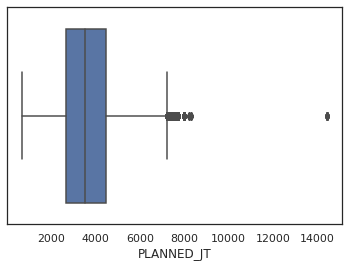

In [106]:
# Create boxplot for feature PLANNEDTIME_ARR
sns.boxplot(final_updated["PLANNED_JT"])

<p>We can see that PLANNED_JT also contains some outliers, however these entries will be retained for now. MAE between PLANNED_JT and JOURNEYTIME will be used as a comparison for the MAE of our models. It is our aim to create a prediction model which outperforms the static schedules i.e. planned journey times used by Dublin Bus.</p>

In [107]:
final_updated.columns

Index(['LINEID', 'ROUTEID', 'DIRECTION', 'PLANNEDTIME_ARR', 'PLANNEDTIME_DEP',
       'ACTUALTIME_ARR', 'ACTUALTIME_DEP', 'temp', 'feels_like', 'temp_min',
       'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg',
       'clouds_all', 'weather_main_Clouds', 'weather_main_Drizzle',
       'weather_main_Fog', 'weather_main_Mist', 'weather_main_Rain',
       'weather_main_Smoke', 'weather_main_Snow', 'precipitation_true_1',
       'MONTH_1', 'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6',
       'MONTH_7', 'MONTH_8', 'MONTH_9', 'MONTH_10', 'MONTH_11', 'WEEKDAY_1',
       'WEEKDAY_2', 'WEEKDAY_3', 'WEEKDAY_4', 'WEEKDAY_5', 'WEEKDAY_6',
       'HOUR_3', 'HOUR_4', 'HOUR_5', 'HOUR_6', 'HOUR_7', 'HOUR_8', 'HOUR_9',
       'HOUR_10', 'HOUR_11', 'HOUR_12', 'HOUR_13', 'HOUR_14', 'HOUR_15',
       'HOUR_16', 'HOUR_17', 'HOUR_18', 'HOUR_19', 'HOUR_20', 'HOUR_21',
       'HOUR_22', 'HOUR_23', 'weekend_true_1', 'peak_true_1', 'HOUR_1',
       'HOUR_2', 'JOURNEYTIME', 'OUTLIER', 'PLA

In [108]:
final_updated.drop(["LINEID", "PLANNEDTIME_ARR", "PLANNEDTIME_DEP", "ACTUALTIME_ARR", "ACTUALTIME_DEP", "OUTLIER"], axis = 1, inplace=True)

In [109]:
final_updated.to_csv("missforest_imputed_outliers_removed_all_features.csv", index=False)